This notebook is a tutorial for training and prediction in data1.

# Load Dependencies

In [15]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import numpy as np
import pandas as pd
import tensorflow as tf
from rdkit import Chem
from script.MIGNN_model import Graph_DataLoader,MIGNN_model1
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import os 
os.environ["CUDA_DEVICE_ORDER"] = "1"

2023-02-20 20:39:02.094237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:39:02.094746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:39:02.095055: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/anaconda3/envs/SEMG/lib/python3.8/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause 

# Load Steric and Electronic Information

In [3]:
react_spms = np.load('./data1/run_data/data1_SEMG_MIGNN_react_spms.npy')
react_elec = np.load('./data1/run_data/data1_SEMG_MIGNN_react_elec.npy')
labels = np.load('./data1/run_data/data1_SEMG_MIGNN_labels.npy')
label_std = np.load('./data1/run_data/data1_SEMG_MIGNN_label_std.npy')

# Train model

## Interpolative Task

In [4]:
batch_size = 128
np.random.seed(2021)
shuffle = np.array(list(range(len(react_spms))))
np.random.shuffle(shuffle)
train_index = shuffle[:int(0.7*len(react_spms))]
val_index = shuffle[int(0.7*len(react_spms)):]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

spms_train_std=(spms_train-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
elec_train_std=(elec_train-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))
spms_val_std=(spms_val-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
elec_val_std=(elec_val-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))
y_train_std=(y_train-y_train.min())/(y_train.max()-y_train.min())
y_val_std=(y_val-y_train.min())/(y_train.max()-y_train.min())                                            
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()

/tmp/ipykernel_2123497/1514558296.py:10: RuntimeWarning: invalid value encountered in true_divide
  spms_train_std=(spms_train-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
/tmp/ipykernel_2123497/1514558296.py:11: RuntimeWarning: invalid value encountered in true_divide
  elec_train_std=(elec_train-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))
/tmp/ipykernel_2123497/1514558296.py:12: RuntimeWarning: invalid value encountered in true_divide
  spms_val_std=(spms_val-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
/tmp/ipykernel_2123497/1514558296.py:13: RuntimeWarning: invalid value encountered in true_divide
  elec_val_std=(elec_val-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))


In [5]:
model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='none')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 100
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_random.ckpt')
    print("model saved to %s" % path)  

2023-02-20 20:10:21.565192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:10:21.565429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:10:21.565603: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


22/22 [==============================] - 14s 461ms/step - loss: 0.0836 - val_loss: 0.0604
model saved to ./data1/run_data/data1_random.ckpt-1
22/22 [==============================] - 10s 432ms/step - loss: 0.0443 - val_loss: 0.0481
model saved to ./data1/run_data/data1_random.ckpt-2
22/22 [==============================] - 10s 437ms/step - loss: 0.0316 - val_loss: 0.0866
model saved to ./data1/run_data/data1_random.ckpt-3
22/22 [==============================] - 10s 435ms/step - loss: 0.0244 - val_loss: 0.1407
model saved to ./data1/run_data/data1_random.ckpt-4
22/22 [==============================] - 10s 434ms/step - loss: 0.0198 - val_loss: 0.2316
model saved to ./data1/run_data/data1_random.ckpt-5
22/22 [==============================] - 10s 434ms/step - loss: 0.0155 - val_loss: 0.1102
model saved to ./data1/run_data/data1_random.ckpt-6
22/22 [==============================] - 10s 434ms/step - loss: 0.0122 - val_loss: 0.0602
model saved to ./data1/run_data/data1_random.ckpt-7
22/22 

In [6]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='none')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_random.ckpt-100') 
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*(y_train.max()-y_train.min())+y_train.min()
y_pred[np.where(y_pred<0)]=0

10/10 [==============================] - 2s 129ms/step


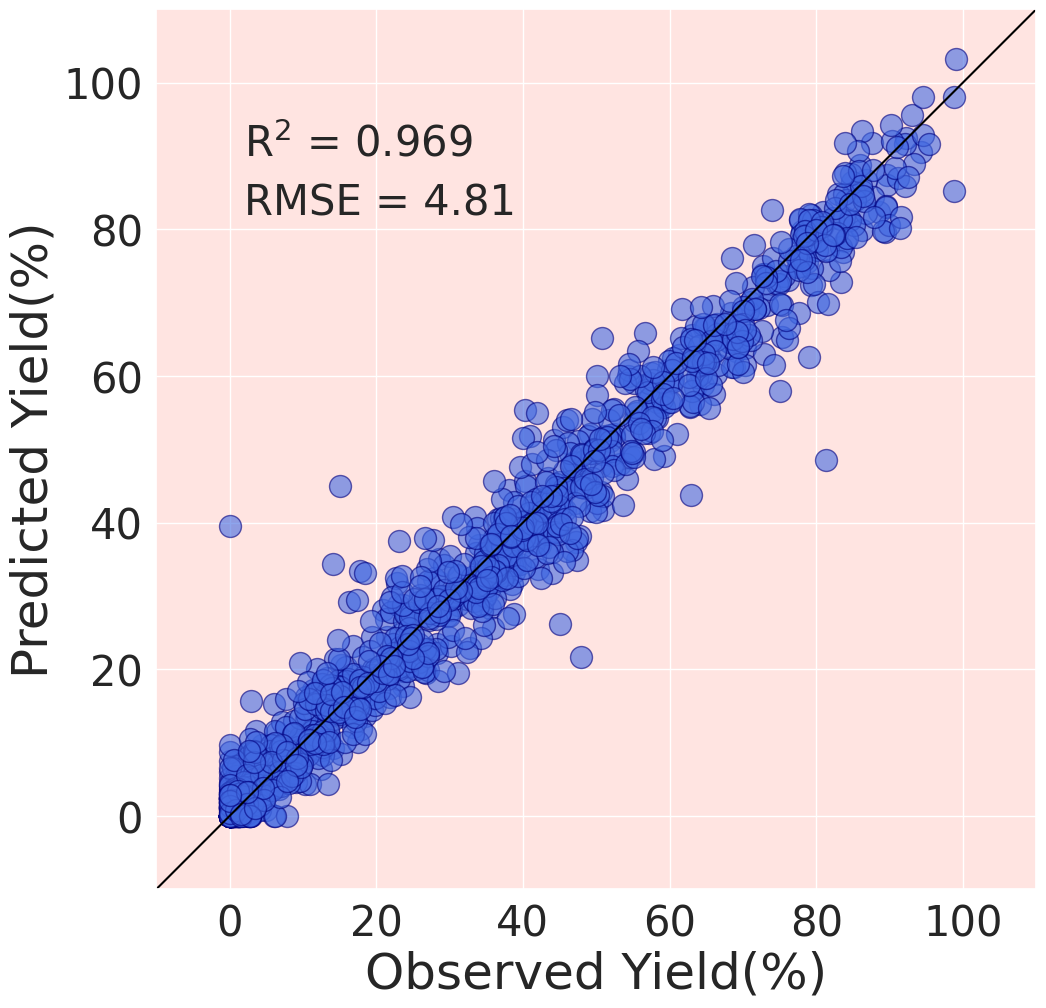

In [8]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',  
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)

plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [6]:
np.save('./result/data1_SEMG_MIGNN_y_val.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred.npy',y_pred)

## Extrapolative Tasks

In [4]:
data_file = '.Data/data1/data1.csv'
mol_dir = './Data/data1/xtb_sdf/'

tmp_df = pd.read_csv(data_file)
lig_smiles = np.array(tmp_df['Ligand'].to_list())
add_smiles = np.array(tmp_df['Additive'].to_list())
base_smiles = np.array(tmp_df['Base'].to_list())
ar_ha_smiles = np.array(tmp_df['Aryl halide'].to_list())
labels = np.array(tmp_df['Output'].to_list())
label_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

lig_smi_set = list(set(lig_smiles))
add_smi_set = list(set(add_smiles))
base_smi_set = list(set(base_smiles))
ar_ha_smi_set = list(set(ar_ha_smiles))

### Ligand Splitting

0 CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C(OC)=CC=C2OC
1 CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2
2 CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C=CC=C2
3 CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC


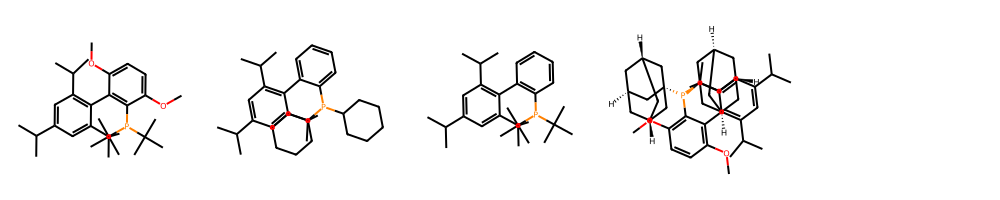

In [5]:
mols=[Chem.MolFromSmiles(smi) for smi in lig_smi_set]
for index,i in enumerate(lig_smi_set):
    print(index,i)
Chem.Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200))

In [ ]:
train_cat = ['CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC',
 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C(OC)=CC=C2OC']
test_cat = ['CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C=CC=C2',
            'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(lig_smiles):
    if tmp_smi in train_cat:
        train_index.append(tmp_idx)
    elif tmp_smi in test_cat:
        val_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 50
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_sca_lig.ckpt')
    print("model saved to %s" % path)  

16/16 [==============================] - 4s 188ms/step


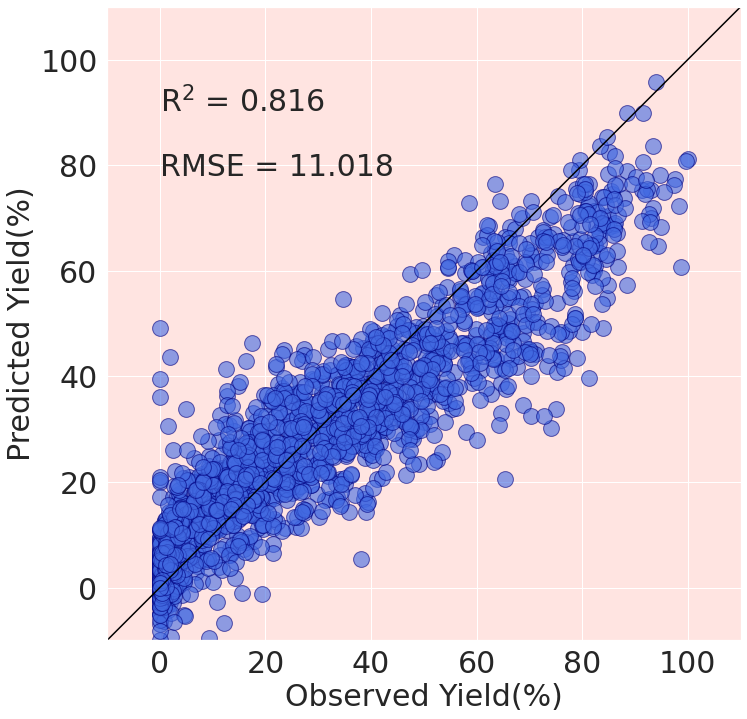

In [12]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='none')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_sca_lig.ckpt-50') # 46
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [11]:
np.save('./result/data1_SEMG_MIGNN_y_val_sca_lig.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_sca_lig.npy',y_pred)

### Aryl Halide Splitting

0 BrC1=CN=CC=C1
1 BrC1=NC=CC=C1
2 IC1=NC=CC=C1
3 IC1=CN=CC=C1
4 ClC1=CN=CC=C1
5 ClC1=NC=CC=C1


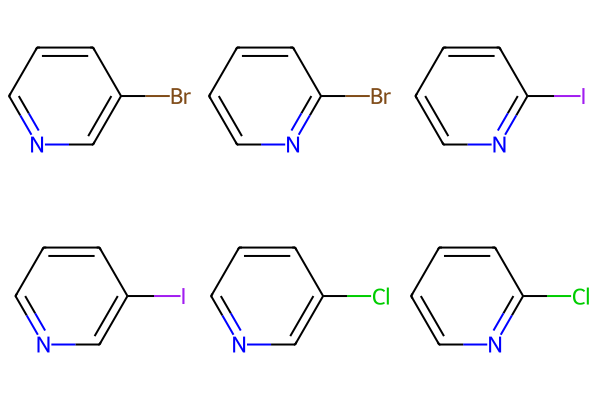

In [15]:
train_ar_ha = ['IC1=CC=C(C(F)(F)F)C=C1', 'BrC1=CC=C(OC)C=C1', 
             'BrC1=CC=C(C(F)(F)F)C=C1', 'IC1=CC=C(OC)C=C1', 'ClC1=CC=C(CC)C=C1', 'ClC1=CC=C(C(F)(F)F)C=C1', 'BrC1=CC=C(CC)C=C1', 
             'IC1=CC=C(CC)C=C1', 'ClC1=CC=C(OC)C=C1']
test_ar_ha = ['BrC1=CN=CC=C1', 'BrC1=NC=CC=C1', 'IC1=NC=CC=C1', 'IC1=CN=CC=C1', 'ClC1=CN=CC=C1', 'ClC1=NC=CC=C1']

mols=[Chem.MolFromSmiles(smi) for smi in test_ar_ha]
for index,i in enumerate(test_ar_ha):
    print(index,i)
Chem.Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200))

In [ ]:
train_ar_ha = ['IC1=CC=C(C(F)(F)F)C=C1', 'BrC1=CC=C(OC)C=C1', 
             'BrC1=CC=C(C(F)(F)F)C=C1', 'IC1=CC=C(OC)C=C1', 'ClC1=CC=C(CC)C=C1', 'ClC1=CC=C(C(F)(F)F)C=C1', 'BrC1=CC=C(CC)C=C1', 
             'IC1=CC=C(CC)C=C1', 'ClC1=CC=C(OC)C=C1']
test_ar_ha = ['BrC1=CN=CC=C1', 'BrC1=NC=CC=C1', 'IC1=NC=CC=C1', 'IC1=CN=CC=C1', 'ClC1=CN=CC=C1', 'ClC1=NC=CC=C1']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(ar_ha_smiles):
    if tmp_smi in train_ar_ha:
        train_index.append(tmp_idx)
    elif tmp_smi in test_ar_ha:
        val_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 50
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_sca_ar_ha.ckpt')
    print("model saved to %s" % path)  

13/13 [==============================] - 3s 161ms/step


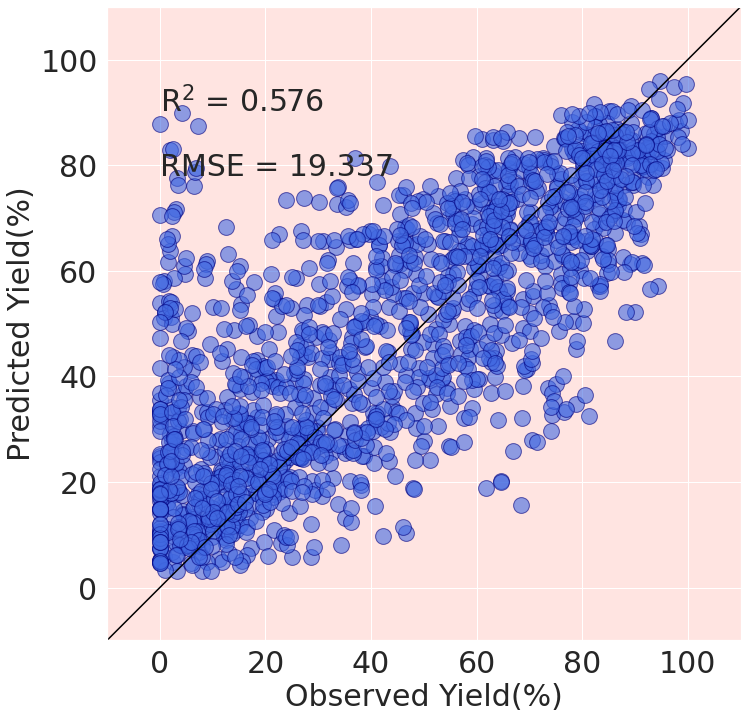

In [28]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_sca_ar_ha.ckpt-50') 
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100
np.save('./result/data1_SEMG_MIGNN_y_val_sca_ar_ha.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_sca_ar_ha.npy',y_pred)

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

### Additive Splitting

0 O=C(OC)C1=NOC(C2=CC=CS2)=C1
1 CC1=NOC(C(OCC)=O)=C1
2 COC1=NOC(C(OCC)=O)=C1
3 CC1=CC(N2C=CC=C2)=NO1
4 O=C(OC)C1=NOC(C2=CC=CO2)=C1
5 C12=CON=C1C=CC=C2
6 C12=C(C=CC=C2)ON=C1
7 CC1=CC(C)=NO1
8 CC1=C(C(OCC)=O)C=NO1
9 CC1=NOC(C2=CC=CC=C2)=C1
10 CC1=CC(C(OCC)=O)=NO1


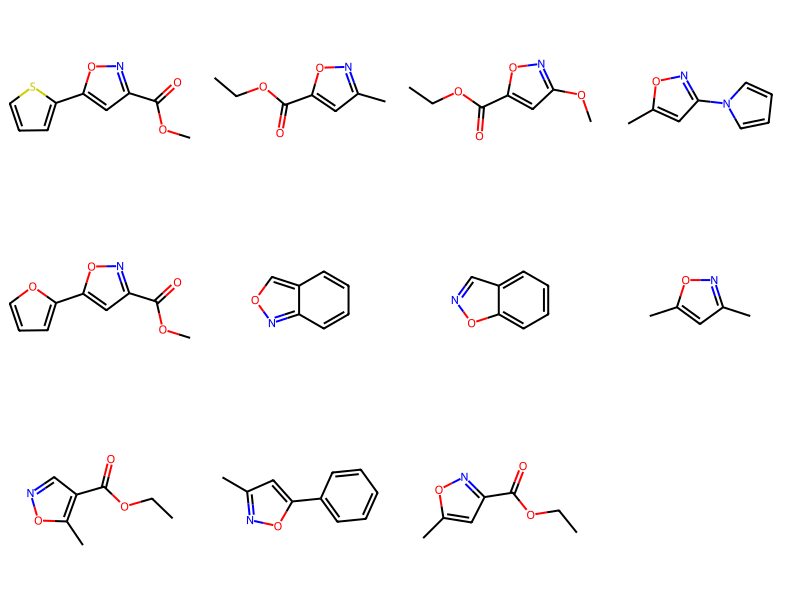

In [16]:
train_add = ['CCOC(C1=NOC=C1)=O', 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1', 'C1(C2=CC=CC=C2)=CC=NO1', 'C1(C2=CC=CC=C2)=NOC=C1',
                'FC(C=CC=C1F)=C1C2=CC=NO2', 'CCOC(C1=CON=C1)=O', 
                'O=C(OC)C1=CC=NO1', 'CC1=NOC=C1', 'CC1=CC=NO1',
                'C1(C2=CC=CC=C2)=CON=C1',
                'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1']
test_add = ['O=C(OC)C1=NOC(C2=CC=CS2)=C1','CC1=NOC(C(OCC)=O)=C1', 'COC1=NOC(C(OCC)=O)=C1', 'CC1=CC(N2C=CC=C2)=NO1','O=C(OC)C1=NOC(C2=CC=CO2)=C1',
              'C12=CON=C1C=CC=C2','C12=C(C=CC=C2)ON=C1', 'CC1=CC(C)=NO1', 'CC1=C(C(OCC)=O)C=NO1', 'CC1=NOC(C2=CC=CC=C2)=C1','CC1=CC(C(OCC)=O)=NO1']


mols=[Chem.MolFromSmiles(smi) for smi in test_add]
for index,i in enumerate(test_add):
    print(index,i)
Chem.Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200))

0 CCOC(C1=NOC=C1)=O
1 C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1
2 C1(C2=CC=CC=C2)=CC=NO1
3 C1(C2=CC=CC=C2)=NOC=C1
4 FC(C=CC=C1F)=C1C2=CC=NO2
5 CCOC(C1=CON=C1)=O
6 O=C(OC)C1=CC=NO1
7 CC1=NOC=C1
8 CC1=CC=NO1
9 C1(C2=CC=CC=C2)=CON=C1
10 C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1


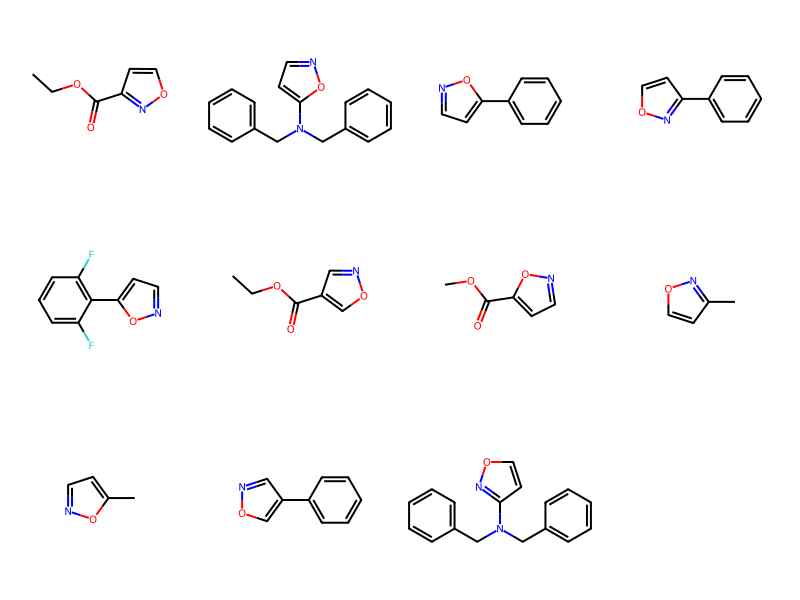

In [17]:
mols=[Chem.MolFromSmiles(smi) for smi in train_add]
for index,i in enumerate(train_add):
    print(index,i)
Chem.Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200))

In [5]:
train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if tmp_smi in train_add:
        train_index.append(tmp_idx)
    elif tmp_smi in test_add:
        val_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_sca_add.ckpt')
    print("model saved to %s" % path)  

2022-12-12 15:17:58.080565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 15:17:58.080872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 15:17:58.081044: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


16/16 [==============================] - 15s 574ms/step - loss: 0.0857 - val_loss: 0.0772
model saved to ./data1/run_data/data1_sca_add.ckpt-1
16/16 [==============================] - 8s 527ms/step - loss: 0.0599 - val_loss: 0.1067
model saved to ./data1/run_data/data1_sca_add.ckpt-2
16/16 [==============================] - 8s 530ms/step - loss: 0.0418 - val_loss: 0.0883
model saved to ./data1/run_data/data1_sca_add.ckpt-3
16/16 [==============================] - 9s 551ms/step - loss: 0.0369 - val_loss: 0.1338
model saved to ./data1/run_data/data1_sca_add.ckpt-4
16/16 [==============================] - 8s 534ms/step - loss: 0.0250 - val_loss: 0.1299
model saved to ./data1/run_data/data1_sca_add.ckpt-5
16/16 [==============================] - 9s 539ms/step - loss: 0.0159 - val_loss: 0.0860
model saved to ./data1/run_data/data1_sca_add.ckpt-6
16/16 [==============================] - 8s 529ms/step - loss: 0.0124 - val_loss: 0.0871
model saved to ./data1/run_data/data1_sca_add.ckpt-7
16/16

model saved to ./data1/run_data/data1_sca_add.ckpt-57
16/16 [==============================] - 8s 533ms/step - loss: 4.0172e-04 - val_loss: 0.0535
model saved to ./data1/run_data/data1_sca_add.ckpt-58
16/16 [==============================] - 8s 532ms/step - loss: 4.4481e-04 - val_loss: 0.0545
model saved to ./data1/run_data/data1_sca_add.ckpt-59
16/16 [==============================] - 8s 528ms/step - loss: 4.1750e-04 - val_loss: 0.0530
model saved to ./data1/run_data/data1_sca_add.ckpt-60
16/16 [==============================] - 8s 526ms/step - loss: 3.6173e-04 - val_loss: 0.0539
model saved to ./data1/run_data/data1_sca_add.ckpt-61
16/16 [==============================] - 9s 544ms/step - loss: 3.3115e-04 - val_loss: 0.0534
model saved to ./data1/run_data/data1_sca_add.ckpt-62
16/16 [==============================] - 8s 533ms/step - loss: 3.2301e-04 - val_loss: 0.0525
model saved to ./data1/run_data/data1_sca_add.ckpt-63
16/16 [==============================] - 8s 525ms/step - loss: 2

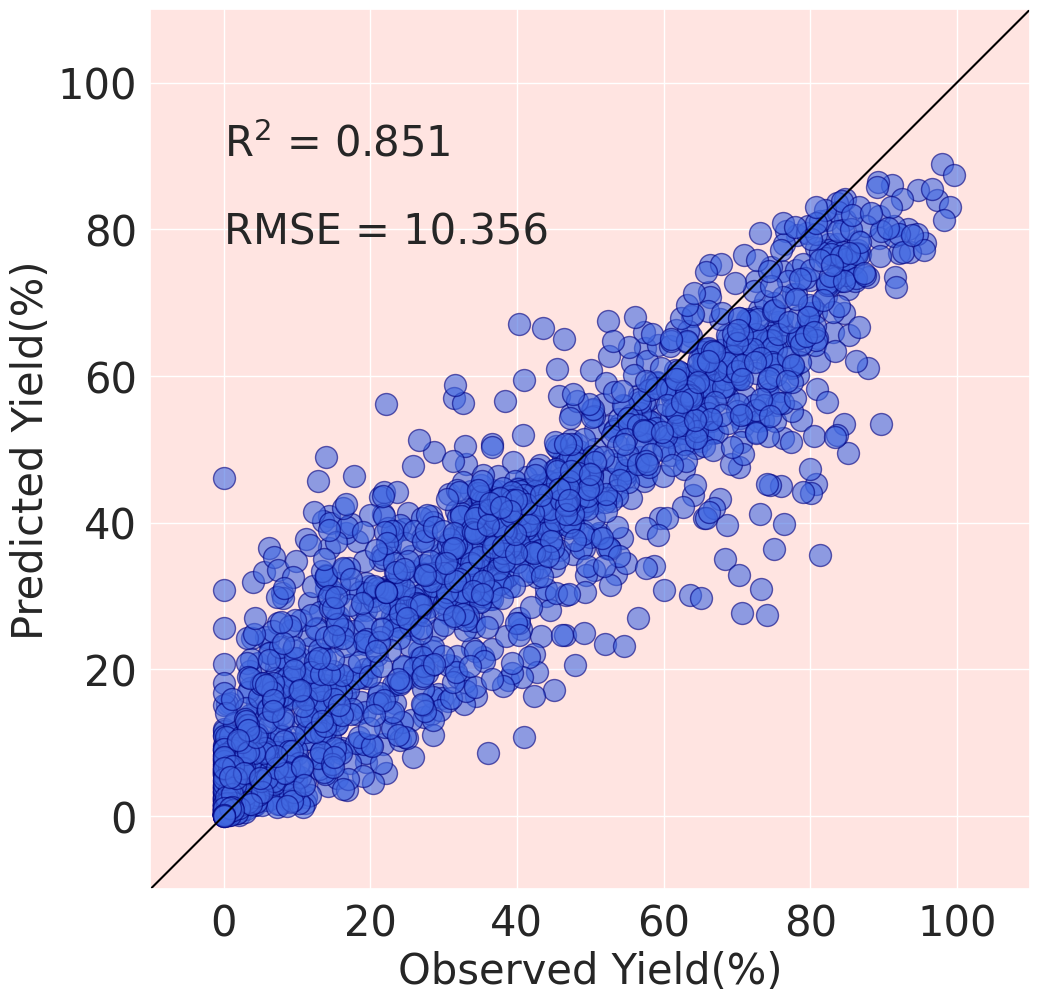

In [21]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_sca_add.ckpt-70') 
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100

np.save('./result/data1_SEMG_MIGNN_y_val_sca_add.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_sca_add.npy',y_pred)

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

### Base Splitting

In [4]:
train_base = ['CN1CCCN2C1=NCCC2',
 'CC(C)(C)/N=C(N(C)C)/N(C)C']
test_base = ['CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(base_smiles):
    if tmp_smi in train_base:
        train_index.append(tmp_idx)
    elif tmp_smi in test_base:
        val_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_sca_base.ckpt')
    print("model saved to %s" % path)  

2022-12-12 15:40:16.254333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 15:40:16.254569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 15:40:16.254708: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


21/21 [==============================] - 17s 501ms/step - loss: 0.0767 - val_loss: 0.0521
model saved to ./data1/run_data/data1_sca_base.ckpt-1
21/21 [==============================] - 10s 470ms/step - loss: 0.0536 - val_loss: 0.0573
model saved to ./data1/run_data/data1_sca_base.ckpt-2
21/21 [==============================] - 10s 462ms/step - loss: 0.0453 - val_loss: 0.0732
model saved to ./data1/run_data/data1_sca_base.ckpt-3
21/21 [==============================] - 10s 463ms/step - loss: 0.0251 - val_loss: 0.0462
model saved to ./data1/run_data/data1_sca_base.ckpt-4
21/21 [==============================] - 10s 460ms/step - loss: 0.0122 - val_loss: 0.0567
model saved to ./data1/run_data/data1_sca_base.ckpt-5
21/21 [==============================] - 10s 462ms/step - loss: 0.0084 - val_loss: 0.0404
model saved to ./data1/run_data/data1_sca_base.ckpt-6
21/21 [==============================] - 10s 471ms/step - loss: 0.0072 - val_loss: 0.0416
model saved to ./data1/run_data/data1_sca_base

21/21 [==============================] - 10s 457ms/step - loss: 5.5519e-04 - val_loss: 0.0389
model saved to ./data1/run_data/data1_sca_base.ckpt-57
21/21 [==============================] - 10s 458ms/step - loss: 4.3598e-04 - val_loss: 0.0387
model saved to ./data1/run_data/data1_sca_base.ckpt-58
21/21 [==============================] - 10s 468ms/step - loss: 3.5106e-04 - val_loss: 0.0379
model saved to ./data1/run_data/data1_sca_base.ckpt-59
21/21 [==============================] - 10s 467ms/step - loss: 3.5526e-04 - val_loss: 0.0396
model saved to ./data1/run_data/data1_sca_base.ckpt-60
21/21 [==============================] - 10s 459ms/step - loss: 3.6094e-04 - val_loss: 0.0377
model saved to ./data1/run_data/data1_sca_base.ckpt-61
21/21 [==============================] - 10s 464ms/step - loss: 3.7237e-04 - val_loss: 0.0388
model saved to ./data1/run_data/data1_sca_base.ckpt-62
21/21 [==============================] - 10s 463ms/step - loss: 3.6986e-04 - val_loss: 0.0375
model saved 

11/11 [==============================] - 2s 132ms/step


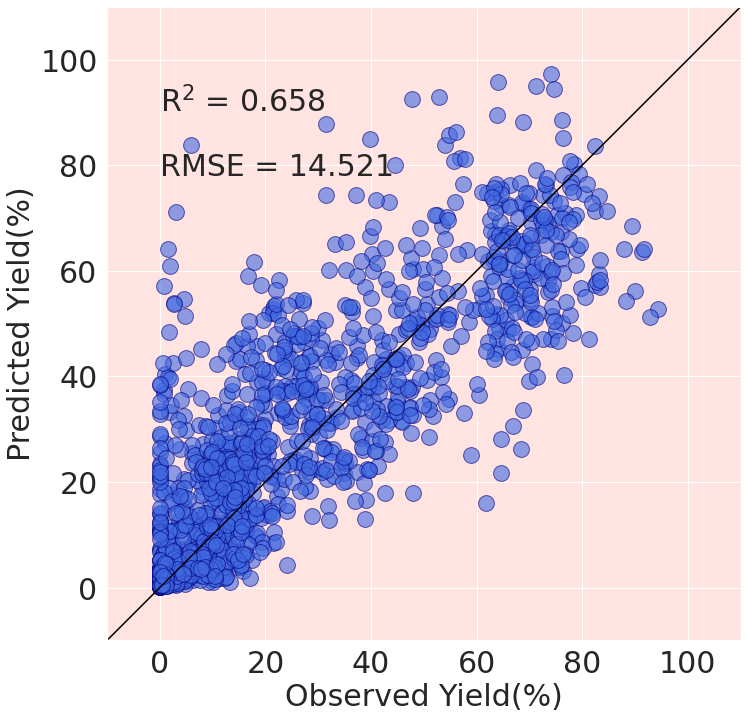

In [6]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_sca_base.ckpt-70') 
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100
np.save('./result/data1_SEMG_MIGNN_y_val_sca_base.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_sca_base.npy',y_pred)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

## Additive Tasks

In [5]:
add_id_map_dict={2: 'o1nccc1c2ccccc2',
 4: 'CCOC(=O)c1onc(C)c1',
 6: 'CCOC(=O)c1cc(C)on1',
 1: 'o1cc(cn1)c2ccccc2',
 3: 'o1ccc(n1)c2ccccc2',
 5: 'Cc1ccon1',
 7: 'c1ccc(-c2ncno2)cc1',
 8: 'Cc1oncc1',
 10: 'o1cc2ccccc2n1',
 12: 'Cc1onc(C)c1',
 14: 'COC(=O)c1oncc1',
 9: 'CCOC(=O)c1ccon1',
 11: 'CCOC(=O)c1cnoc1C',
 13: 'CCOC(=O)c1conc1',
 15: 'o1ncc2ccccc12',
 23: 'CCOC(=O)c1onc(OC)c1',
 17: 'Cc1cc(on1)c2ccccc2',
 19: 'C(N(Cc1ccccc1)c2ccon2)c3ccccc3',
 21: 'COC(=O)c1cc(on1)c2occc2',
 16: 'Fc1cccc(F)c1c2oncc2',
 18: 'C(N(Cc1ccccc1)c2oncc2)c3ccccc3',
 20: 'Cc1onc(c1)n2cccc2',
 22: 'COC(=O)c1cc(on1)c2sccc2'}
train_add_idx = [1,2,3,4,5,6,8,9,10,11,12,13,14,15]
train_add_smi_uniq = [add_id_map_dict[tmp_idx] for tmp_idx in train_add_idx]
test_add_idx = [16,17,18,19,20,21,22,23]
test_add_smi_uniq = [add_id_map_dict[tmp_idx] for tmp_idx in test_add_idx]

0 Fc1cccc(F)c1c2oncc2
1 Cc1cc(on1)c2ccccc2
2 C(N(Cc1ccccc1)c2oncc2)c3ccccc3
3 C(N(Cc1ccccc1)c2ccon2)c3ccccc3
4 Cc1onc(c1)n2cccc2
5 COC(=O)c1cc(on1)c2occc2
6 COC(=O)c1cc(on1)c2sccc2
7 CCOC(=O)c1onc(OC)c1


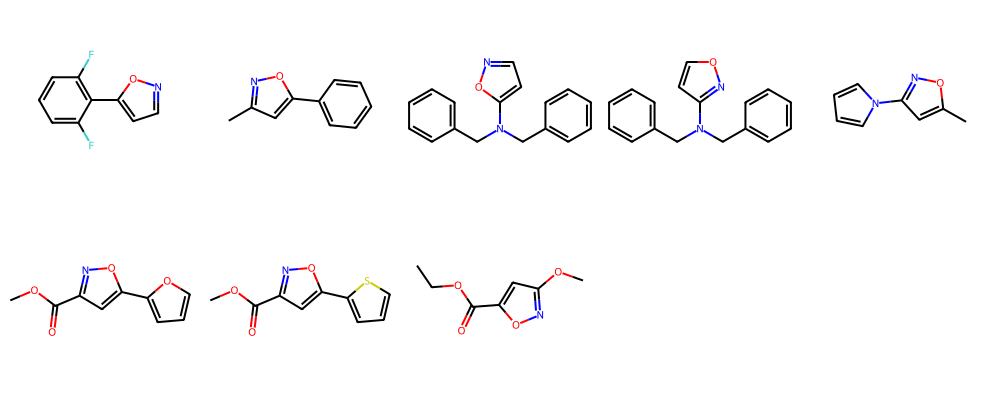

In [10]:
mols=[Chem.MolFromSmiles(smi) for smi in test_add_smi_uniq]
for index,i in enumerate(test_add_smi_uniq):
    print(index,i)
Chem.Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200))

### 1

In [29]:
train_add = train_add_smi_uniq
test_add = test_add_smi_uniq[0]

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(test_add)):
        val_index.append(tmp_idx)
    for j in train_add:
        if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(j)):
            train_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_oos_add1.ckpt')
    print("model saved to %s" % path)  

20/20 [==============================] - 14s 435ms/step - loss: 0.0874 - val_loss: 0.0419
model saved to ./data1/run_data/data1_oos_add1.ckpt-1
20/20 [==============================] - 8s 401ms/step - loss: 0.0587 - val_loss: 0.0523
model saved to ./data1/run_data/data1_oos_add1.ckpt-2
20/20 [==============================] - 8s 395ms/step - loss: 0.0469 - val_loss: 0.0415
model saved to ./data1/run_data/data1_oos_add1.ckpt-3
20/20 [==============================] - 8s 396ms/step - loss: 0.0367 - val_loss: 0.0281
model saved to ./data1/run_data/data1_oos_add1.ckpt-4
20/20 [==============================] - 8s 407ms/step - loss: 0.0270 - val_loss: 0.0197
model saved to ./data1/run_data/data1_oos_add1.ckpt-5
20/20 [==============================] - 8s 406ms/step - loss: 0.0217 - val_loss: 0.0372
model saved to ./data1/run_data/data1_oos_add1.ckpt-6
20/20 [==============================] - 8s 393ms/step - loss: 0.0171 - val_loss: 0.0465
model saved to ./data1/run_data/data1_oos_add1.ckpt-

2/2 [==============================] - 1s 49ms/step


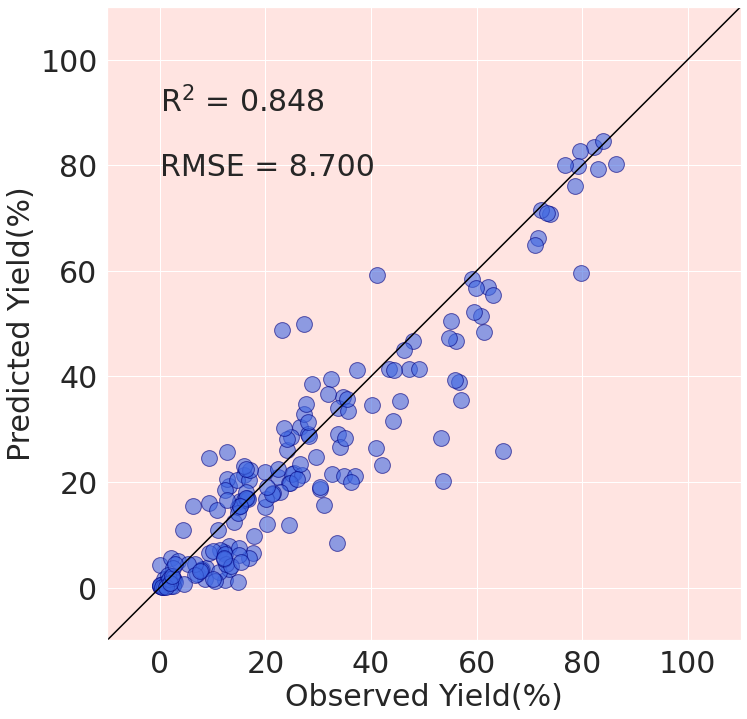

In [33]:
train_add = train_add_smi_uniq
test_add = test_add_smi_uniq[0]

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(test_add)):
        val_index.append(tmp_idx)
    for j in train_add:
        if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(j)):
            train_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_oos_add1.ckpt-70') 
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100
np.save('./result/data1_SEMG_MIGNN_y_val_oos_add1.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_oos_add1.npy',y_pred)

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

### 2

In [10]:
train_add = train_add_smi_uniq
test_add = test_add_smi_uniq[1]

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(test_add)):
        val_index.append(tmp_idx)
    for j in train_add:
        if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(j)):
            train_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_oos_add2.ckpt')
    print("model saved to %s" % path)  

20/20 [==============================] - 15s 471ms/step - loss: 0.0843 - val_loss: 0.0763
model saved to ./data1/run_data/data1_oos_add2.ckpt-1
20/20 [==============================] - 9s 438ms/step - loss: 0.0569 - val_loss: 0.0633
model saved to ./data1/run_data/data1_oos_add2.ckpt-2
20/20 [==============================] - 9s 448ms/step - loss: 0.0489 - val_loss: 0.0569
model saved to ./data1/run_data/data1_oos_add2.ckpt-3
20/20 [==============================] - 9s 442ms/step - loss: 0.0425 - val_loss: 0.0387
model saved to ./data1/run_data/data1_oos_add2.ckpt-4
20/20 [==============================] - 9s 449ms/step - loss: 0.0275 - val_loss: 0.0213
model saved to ./data1/run_data/data1_oos_add2.ckpt-5
20/20 [==============================] - 9s 442ms/step - loss: 0.0168 - val_loss: 0.0324
model saved to ./data1/run_data/data1_oos_add2.ckpt-6
20/20 [==============================] - 9s 431ms/step - loss: 0.0116 - val_loss: 0.0252
model saved to ./data1/run_data/data1_oos_add2.ckpt-

2/2 [==============================] - 1s 48ms/step


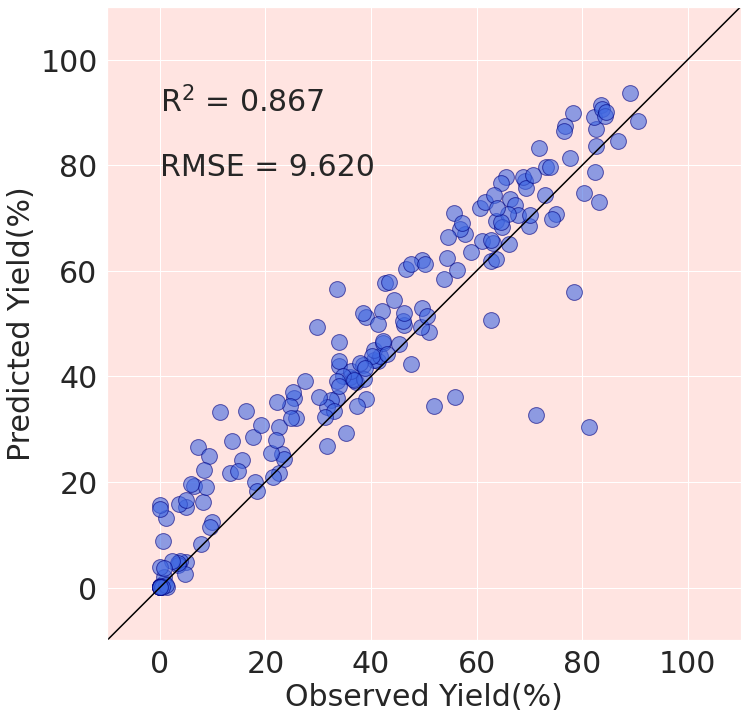

In [18]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_oos_add2.ckpt-70') # 46
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100
np.save('./result/data1_SEMG_MIGNN_y_val_oos_add2.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_oos_add2.npy',y_pred)

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

### 3

In [12]:
train_add = train_add_smi_uniq
test_add = test_add_smi_uniq[2]

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(test_add)):
        val_index.append(tmp_idx)
    for j in train_add:
        if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(j)):
            train_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_oos_add3.ckpt')
    print("model saved to %s" % path)  

20/20 [==============================] - 15s 467ms/step - loss: 0.0829 - val_loss: 0.0506
model saved to ./data1/run_data/data1_oos_add3.ckpt-1
20/20 [==============================] - 9s 425ms/step - loss: 0.0556 - val_loss: 0.0486
model saved to ./data1/run_data/data1_oos_add3.ckpt-2
20/20 [==============================] - 9s 427ms/step - loss: 0.0463 - val_loss: 0.0482
model saved to ./data1/run_data/data1_oos_add3.ckpt-3
20/20 [==============================] - 8s 419ms/step - loss: 0.0415 - val_loss: 0.0383
model saved to ./data1/run_data/data1_oos_add3.ckpt-4
20/20 [==============================] - 8s 420ms/step - loss: 0.0269 - val_loss: 0.0295
model saved to ./data1/run_data/data1_oos_add3.ckpt-5
20/20 [==============================] - 9s 431ms/step - loss: 0.0161 - val_loss: 0.0242
model saved to ./data1/run_data/data1_oos_add3.ckpt-6
20/20 [==============================] - 9s 435ms/step - loss: 0.0107 - val_loss: 0.0182
model saved to ./data1/run_data/data1_oos_add3.ckpt-

2/2 [==============================] - 1s 51ms/step


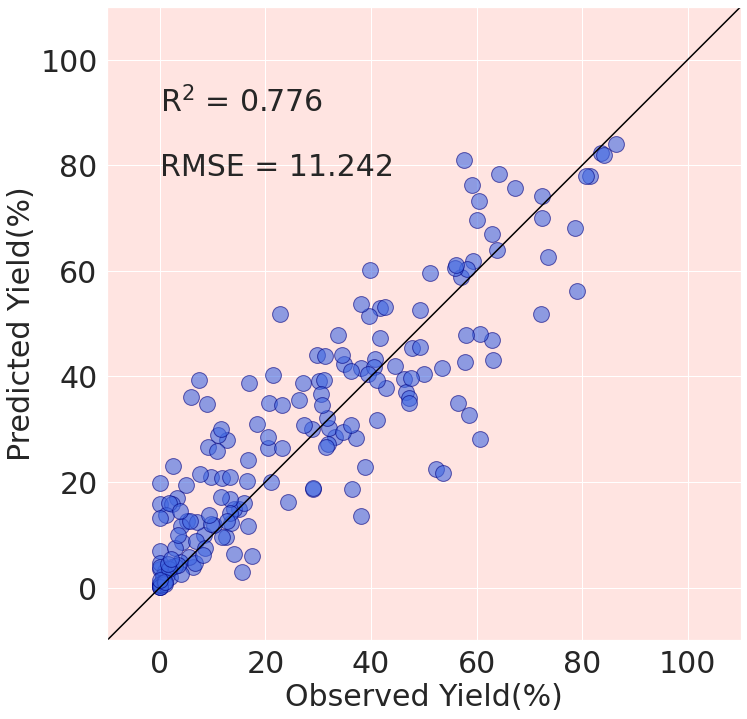

In [13]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_oos_add3.ckpt-70') # 46
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100
np.save('./result/data1_SEMG_MIGNN_y_val_oos_add3.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_oos_add3.npy',y_pred)

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

### 4

In [14]:
train_add = train_add_smi_uniq
test_add = test_add_smi_uniq[3]

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(test_add)):
        val_index.append(tmp_idx)
    for j in train_add:
        if Chem.MolToSmiles(Chem.MolFromSmiles(tmp_smi))== Chem.MolToSmiles(Chem.MolFromSmiles(j)):
            train_index.append(tmp_idx)
        
batch_size = 128
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

y_train_std=y_train/100
y_val_std=y_val/100
                                                   
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()


model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_oos_add4.ckpt')
    print("model saved to %s" % path)  

20/20 [==============================] - 14s 444ms/step - loss: 0.0850 - val_loss: 0.0967
model saved to ./data1/run_data/data1_oos_add4.ckpt-1
20/20 [==============================] - 8s 406ms/step - loss: 0.0587 - val_loss: 0.0651
model saved to ./data1/run_data/data1_oos_add4.ckpt-2
20/20 [==============================] - 8s 407ms/step - loss: 0.0485 - val_loss: 0.1052
model saved to ./data1/run_data/data1_oos_add4.ckpt-3
20/20 [==============================] - 8s 411ms/step - loss: 0.0444 - val_loss: 0.1233
model saved to ./data1/run_data/data1_oos_add4.ckpt-4
20/20 [==============================] - 8s 407ms/step - loss: 0.0384 - val_loss: 0.0791
model saved to ./data1/run_data/data1_oos_add4.ckpt-5
20/20 [==============================] - 8s 406ms/step - loss: 0.0221 - val_loss: 0.1472
model saved to ./data1/run_data/data1_oos_add4.ckpt-6
20/20 [==============================] - 8s 411ms/step - loss: 0.0144 - val_loss: 0.1229
model saved to ./data1/run_data/data1_oos_add4.ckpt-

2/2 [==============================] - 1s 52ms/step


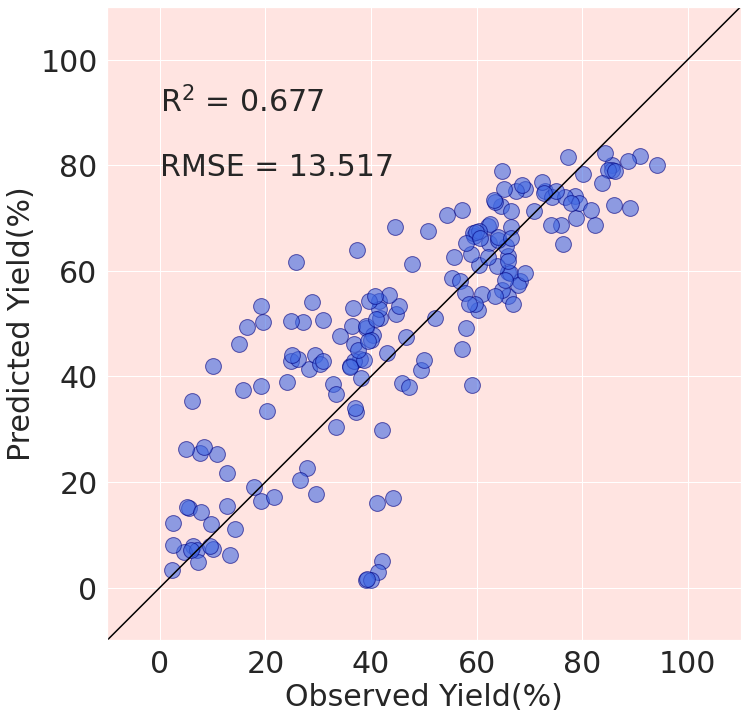

In [14]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,final_act='sigmoid')
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_oos_add4.ckpt-70')
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*100
np.save('./result/data1_SEMG_MIGNN_y_val_oos_add4.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred_oos_add4.npy',y_pred)

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()